In [2]:
import glob, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import findspark


In [3]:
asistencia_df = pd.read_csv('data/senado_asistencia.csv', index_col=0)
asistencia_df.loc[:,'asistencia_comision'] = asistencia_df.apply(lambda x : x['citacion_comision'] - x['falta_con_aviso_comision'] - x['falta_sin_aviso_comision'] - x['licencia_comision'], axis=1)
asistencia_df.loc[:,'citaciones'] = asistencia_df.apply(lambda x : x['citado_camara'] + x['citacion_comision'] , axis=1)
asistencia_df.loc[:,'asistencia'] = asistencia_df.apply(lambda x : x['asistencia_camara'] + x['asistencia_comision'], axis=1)
asistencia_df.loc[:,'faltas_sin_aviso'] = asistencia_df.apply(lambda x : x['faltas_sin_aviso_camara'] + x['falta_sin_aviso_comision'], axis=1)
asistencia_df.loc[:,'asistencia_nota'] = asistencia_df.apply(lambda x : x['asistencia'] * 1.0 / x['citaciones'] * 100 , axis=1)
asistencia_df.loc[:,'faltas_sin_aviso_nota'] = asistencia_df.apply(lambda x : 100 - (x['faltas_sin_aviso'] / x['citaciones'] * 100), axis=1)
asistencia_df.head()

,id_senador,nombre,email,citado_camara,asistencia_camara,falta_con_aviso_camara,faltas_sin_aviso_camara,con_licencia_camara,pasaje_presidencia_camara,citacion_comision,falta_con_aviso_comision,falta_sin_aviso_comision,licencia_comision,otras_comisiones_comision,asistencia_comision,citaciones,asistencia,faltas_sin_aviso,asistencia_nota,faltas_sin_aviso_nota
0,5146,"Agazzi, Ernesto",eagazzi@parlamento.gub.uy,108,98,0,0,10,0,131.0,8.0,0.0,0.0,1.0,123.0,239.0,221.0,0.0,92.468619,100.0
1,2743,"Alcorta, Ricardo",NaN,23,23,0,0,0,0,51.0,5.0,0.0,0.0,1.0,46.0,74.0,69.0,0.0,93.243243,100.0
2,8883,"Almagro Lemes, Luis Leonardo",secretaria.ministro@mrree.gub.uy,13,4,0,0,9,0,12.0,7.0,0.0,0.0,0.0,5.0,25.0,9.0,0.0,36.000000,100.0
3,9891,"Alonso, Verónica",valonso@parlamento.gub.uy,224,132,21,0,71,0,349.0,130.0,0.0,1.0,0.0,218.0,573.0,350.0,0.0,61.082024,100.0
4,11535,"Álvarez López, María Dolores",nolivera@parlamento.gub.uy,6,5,1,0,0,0,19.0,0.0,10.0,0.0,0.0,9.0,25.0,14.0,10.0,56.000000,60.0


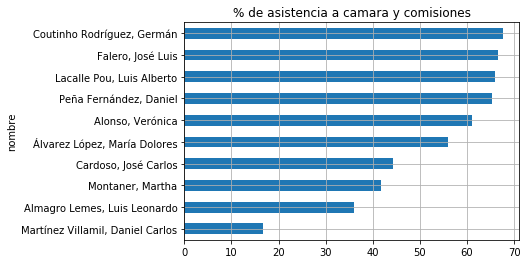

In [4]:
asistencia_df[['nombre', 'asistencia_nota']].set_index('nombre').sort_values(['asistencia_nota'], ascending=True).head(n=10).asistencia_nota.plot.barh(title='% de asistencia a camara y comisiones', grid=True)

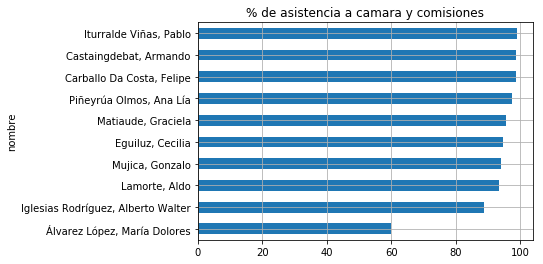

In [5]:
asistencia_df[['nombre', 'faltas_sin_aviso_nota']].set_index('nombre').sort_values(['faltas_sin_aviso_nota'], ascending=True).head(n=10).faltas_sin_aviso_nota.plot.barh(title='% de asistencia a camara y comisiones', grid=True)

In [6]:
trabajo_df = pd.read_csv('data/senado_trabajo.csv', index_col=0)
trabajo_df.head()

,id_senador,titulo,fecha_entrada,id_ficha,organismo,tipo,estado,nombre
0,11536,RAMBLA PORTUARIA. VIVIENDAS PRECARIAS. INCENDI...,2016-10-11,132042,DIRECCION NACIONAL BOMBEROS,PEDIDO_INFORME,REALIZADO,"Pesce Olivera, Viviana"
1,11536,RAMBLA PORUTARIA. VIVIENDAS PRECARIAS. FAMILIA...,2016-10-11,132041,MVOTMA*,PEDIDO_INFORME,REALIZADO,"Pesce Olivera, Viviana"
2,11536,RAMBLA PORTUARIA. VIVIENDAS PRECARIAS. INCENDI...,2016-10-11,132044,MIDES*,PEDIDO_INFORME,REALIZADO,"Pesce Olivera, Viviana"
3,11536,RAMBLA PORTUARIA. VIVIENDAS PRECARIAS. ENERGÍA...,2016-10-11,132045,UTE*,PEDIDO_INFORME,REALIZADO,"Pesce Olivera, Viviana"
4,11536,DELITOS CONTRA MENORES. PREVENCIÓN. MECANISMOS...,2016-07-06,130648,MIDES*,PEDIDO_INFORME,REALIZADO,"Pesce Olivera, Viviana"


In [20]:
senadores_trabajo_df = trabajo_df[['id_senador', 'id_ficha']].groupby(['id_senador']).count().reset_index(level=0)
senadores_trabajo_df = senadores_trabajo_df.merge(trabajo_df[['id_senador', 'nombre']].drop_duplicates(subset=['id_senador']).reset_index(drop=True), on=['id_senador'], how='left')
senadores_trabajo_df = senadores_trabajo_df.rename({'id_ficha': 'cant_tareas'}, axis=1)

senadores_por_tipo_df = trabajo_df[trabajo_df['tipo'] == 'PEDIDO_INFORME'][['id_senador', 'id_ficha']].groupby(['id_senador']).count().reset_index(level=0)
senadores_trabajo_df = senadores_trabajo_df.merge(senadores_por_tipo_df[['id_senador', 'id_ficha']].drop_duplicates(subset=['id_senador']).reset_index(drop=True), on=['id_senador'], how='left')
senadores_trabajo_df = senadores_trabajo_df.rename({'id_ficha': 'cant_pedido_informe'}, axis=1)

senadores_por_tipo_df = trabajo_df[(trabajo_df['tipo'] != 'PEDIDO_INFORME') & (trabajo_df['tipo'] != 'LEY') & (trabajo_df['tipo'] != 'PROYECTO DE LEY')][['id_senador', 'id_ficha']].groupby(['id_senador']).count().reset_index(level=0)
senadores_trabajo_df = senadores_trabajo_df.merge(senadores_por_tipo_df[['id_senador', 'id_ficha']].drop_duplicates(subset=['id_senador']).reset_index(drop=True), on=['id_senador'], how='left')
senadores_trabajo_df = senadores_trabajo_df.rename({'id_ficha': 'cant_otros_tipos'}, axis=1)

senadores_por_tipo_df = trabajo_df[(trabajo_df['tipo'] == 'LEY') | (trabajo_df['tipo'] == 'PROYECTO DE LEY')][['id_senador', 'id_ficha']].groupby(['id_senador']).count().reset_index(level=0)
senadores_trabajo_df = senadores_trabajo_df.merge(senadores_por_tipo_df[['id_senador', 'id_ficha']].drop_duplicates(subset=['id_senador']).reset_index(drop=True), on=['id_senador'], how='left')
senadores_trabajo_df = senadores_trabajo_df.rename({'id_ficha': 'cant_leyes'}, axis=1)

senadores_por_tipo_df = trabajo_df[(trabajo_df['estado'] == 'PROMULGA')][['id_senador', 'id_ficha']].groupby(['id_senador']).count().reset_index(level=0)
senadores_trabajo_df = senadores_trabajo_df.merge(senadores_por_tipo_df[['id_senador', 'id_ficha']].drop_duplicates(subset=['id_senador']).reset_index(drop=True), on=['id_senador'], how='left')
senadores_trabajo_df = senadores_trabajo_df.rename({'id_ficha': 'cant_leyes_aprobado'}, axis=1)
senadores_trabajo_df.head()

,id_senador,cant_tareas,nombre,cant_pedido_informe,cant_otros_tipos,cant_leyes,cant_leyes_aprobado
0,196,58,"Viera Duarte, Tabaré",14.0,19.0,25.0,NaN
1,197,263,"Heber, Luis Alberto",7.0,135.0,121.0,69.0
2,260,132,"Gandini, Jorge",14.0,72.0,46.0,1.0
3,277,335,"Carámbula Volpi, Marcos Gustavo",2.0,45.0,288.0,169.0
4,290,7,"Moreira, Carlos",NaN,NaN,7.0,NaN


In [24]:
senadores_df = asistencia_df.merge(senadores_trabajo_df.drop(columns=['nombre']).reset_index(drop=True), on=['id_senador'], how='left')
senadores_df.head()

,id_senador,nombre,email,citado_camara,asistencia_camara,falta_con_aviso_camara,faltas_sin_aviso_camara,con_licencia_camara,pasaje_presidencia_camara,citacion_comision,...,citaciones,asistencia,faltas_sin_aviso,asistencia_nota,faltas_sin_aviso_nota,cant_tareas,cant_pedido_informe,cant_otros_tipos,cant_leyes,cant_leyes_aprobado
0,5146,"Agazzi, Ernesto",eagazzi@parlamento.gub.uy,108,98,0,0,10,0,131.0,...,239.0,221.0,0.0,92.468619,100.0,267.0,1.0,88.0,178.0,78.0
1,2743,"Alcorta, Ricardo",NaN,23,23,0,0,0,0,51.0,...,74.0,69.0,0.0,93.243243,100.0,3.0,NaN,3.0,NaN,NaN
2,8883,"Almagro Lemes, Luis Leonardo",secretaria.ministro@mrree.gub.uy,13,4,0,0,9,0,12.0,...,25.0,9.0,0.0,36.000000,100.0,1.0,NaN,1.0,NaN,NaN
3,9891,"Alonso, Verónica",valonso@parlamento.gub.uy,224,132,21,0,71,0,349.0,...,573.0,350.0,0.0,61.082024,100.0,183.0,30.0,78.0,75.0,48.0
4,11535,"Álvarez López, María Dolores",nolivera@parlamento.gub.uy,6,5,1,0,0,0,19.0,...,25.0,14.0,10.0,56.000000,60.0,NaN,NaN,NaN,NaN,NaN


In [51]:
max_data = senadores_df[['cant_tareas']].max()[0]
senadores_df.loc[:,'cant_tareas_nota'] = senadores_df['cant_tareas'] / max_data * 100.0

max_data = senadores_df[['cant_pedido_informe']].max()[0]
senadores_df.loc[:,'cant_pedido_informe_nota'] = senadores_df['cant_pedido_informe'] / max_data * 100.0

max_data = senadores_df[['cant_otros_tipos']].max()[0]
senadores_df.loc[:,'cant_otros_tipos_nota'] = senadores_df['cant_otros_tipos'] / max_data * 100.0

max_data = senadores_df[['cant_leyes']].max()[0]
senadores_df.loc[:,'cant_leyes_nota'] = senadores_df['cant_leyes'] / max_data * 100.0

max_data = senadores_df[['cant_leyes_aprobado']].max()[0]
senadores_df.loc[:,'cant_leyes_aprobado_nota'] = senadores_df['cant_leyes_aprobado'] / max_data * 100.0

senadores_df.head()

,id_senador,nombre,email,citado_camara,asistencia_camara,falta_con_aviso_camara,faltas_sin_aviso_camara,con_licencia_camara,pasaje_presidencia_camara,citacion_comision,...,cant_tareas,cant_pedido_informe,cant_otros_tipos,cant_leyes,cant_leyes_aprobado,cant_tareas_nota,cant_pedido_informe_nota,cant_otros_tipos_nota,cant_leyes_nota,cant_leyes_aprobado_nota
0,5146,"Agazzi, Ernesto",eagazzi@parlamento.gub.uy,108,98,0,0,10,0,131.0,...,267.0,1.0,88.0,178.0,78.0,52.046784,2.127660,49.438202,40.454545,32.5
1,2743,"Alcorta, Ricardo",NaN,23,23,0,0,0,0,51.0,...,3.0,NaN,3.0,NaN,NaN,0.584795,NaN,1.685393,NaN,NaN
2,8883,"Almagro Lemes, Luis Leonardo",secretaria.ministro@mrree.gub.uy,13,4,0,0,9,0,12.0,...,1.0,NaN,1.0,NaN,NaN,0.194932,NaN,0.561798,NaN,NaN
3,9891,"Alonso, Verónica",valonso@parlamento.gub.uy,224,132,21,0,71,0,349.0,...,183.0,30.0,78.0,75.0,48.0,35.672515,63.829787,43.820225,17.045455,20.0
4,11535,"Álvarez López, María Dolores",nolivera@parlamento.gub.uy,6,5,1,0,0,0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
w_asistencia_nota=1.0
w_faltas_sin_aviso_nota=1.0
w_cant_tareas_nota=1.0
w_cant_pedido_informe_nota=1.0
w_cant_otros_tipos_nota=1.0
w_cant_leyes_nota=1.0
w_cant_leyes_aprobado_nota=1.0

senadores_df = senadores_df.apply(lambda x : x.fillna('') if x.name == 'email' else x.fillna(0))
senadores_df.loc[:,'nota_general'] = (senadores_df['asistencia_nota'] * w_asistencia_nota + \
    senadores_df['faltas_sin_aviso_nota']  * w_faltas_sin_aviso_nota + \
    senadores_df['cant_tareas_nota'] * w_cant_tareas_nota + \
    senadores_df['cant_pedido_informe_nota'] * w_cant_pedido_informe_nota + \
    senadores_df['cant_otros_tipos_nota'] * w_cant_otros_tipos_nota + \
    senadores_df['cant_leyes_nota'] * w_cant_leyes_nota + \
    senadores_df['cant_leyes_aprobado_nota'] * w_cant_leyes_aprobado_nota) / 7
senadores_df.head()


,id_senador,nombre,email,citado_camara,asistencia_camara,falta_con_aviso_camara,faltas_sin_aviso_camara,con_licencia_camara,pasaje_presidencia_camara,citacion_comision,...,cant_pedido_informe,cant_otros_tipos,cant_leyes,cant_leyes_aprobado,cant_tareas_nota,cant_pedido_informe_nota,cant_otros_tipos_nota,cant_leyes_nota,cant_leyes_aprobado_nota,nota_general
0,5146,"Agazzi, Ernesto",eagazzi@parlamento.gub.uy,108,98,0,0,10,0,131.0,...,1.0,88.0,178.0,78.0,52.046784,2.127660,49.438202,40.454545,32.5,52.719401
1,2743,"Alcorta, Ricardo",,23,23,0,0,0,0,51.0,...,0.0,3.0,0.0,0.0,0.584795,0.000000,1.685393,0.000000,0.0,27.930490
2,8883,"Almagro Lemes, Luis Leonardo",secretaria.ministro@mrree.gub.uy,13,4,0,0,9,0,12.0,...,0.0,1.0,0.0,0.0,0.194932,0.000000,0.561798,0.000000,0.0,19.536676
3,9891,"Alonso, Verónica",valonso@parlamento.gub.uy,224,132,21,0,71,0,349.0,...,30.0,78.0,75.0,48.0,35.672515,63.829787,43.820225,17.045455,20.0,48.778572
4,11535,"Álvarez López, María Dolores",nolivera@parlamento.gub.uy,6,5,1,0,0,0,19.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,16.571429


In [66]:
senadores_df.sort_values(['nota_general'], ascending=True)[['nombre', 'nota_general']].head(n=50)

,nombre,nota_general
106,"Zaffaroni Castilla, María Cecilia",0.000000
92,"Reyes Escudero, María Cristina",0.000000
83,"Peña Hernández, Adriana",0.000000
85,"Piñeiro Rodríguez, Viviana Adalgisa",0.000000
20,"Bonomi, Eduardo",0.000000
59,"Laventure, Martín",0.000000
97,"Simois, Mabel",0.000000
12,"Astori, Danilo",0.000000
105,"Yavarone, Roberto",0.000000
95,"Sendic, Raúl",2.162084
